In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

In [269]:
data = pd.read_csv('../Dataset/heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0


In [270]:
col = list(data.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(data[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : Sex ChestPainType FastingBS RestingECG ExerciseAngina ST_Slope HeartDisease
Numerical Features : Age RestingBP Cholesterol MaxHR Oldpeak


In [271]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df1 = data.copy(deep = True)

df1['Sex'] = le.fit_transform(df1['Sex'])
df1['ChestPainType'] = le.fit_transform(df1['ChestPainType'])
df1['RestingECG'] = le.fit_transform(df1['RestingECG'])
df1['ExerciseAngina'] = le.fit_transform(df1['ExerciseAngina'])
df1['ST_Slope'] = le.fit_transform(df1['ST_Slope'])

In [272]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

df1['Oldpeak'] = mms.fit_transform(df1[['Oldpeak']])
df1['Age'] = ss.fit_transform(df1[['Age']])
df1['RestingBP'] = ss.fit_transform(df1[['RestingBP']])
df1['Cholesterol'] = ss.fit_transform(df1[['Cholesterol']])
df1['MaxHR'] = ss.fit_transform(df1[['MaxHR']])
df1.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.43,1,1,0.41,0.83,0,1,1.38,0,0.30,2,0
1,-0.48,0,2,1.49,-0.17,0,1,0.75,0,0.41,1,1
2,-1.75,1,1,-0.13,0.77,0,2,-1.53,0,0.30,2,0
3,-0.58,0,0,0.30,0.14,0,1,-1.13,1,0.47,1,1
4,0.05,1,2,0.95,-0.03,0,1,-0.58,0,0.30,2,0


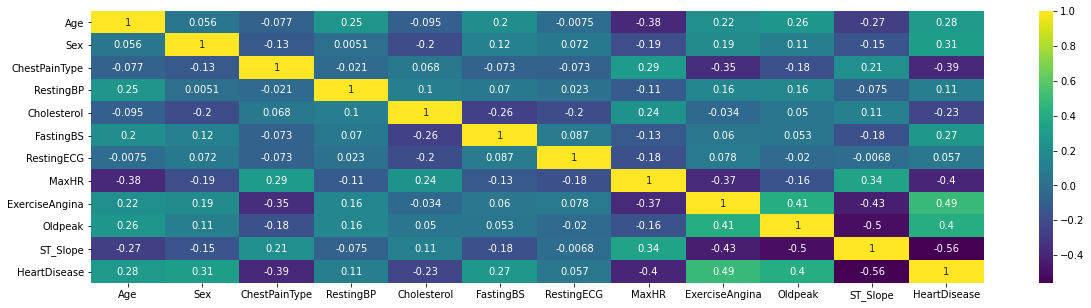

In [273]:
plt.figure(figsize = (20,5))
sns.heatmap(df1.corr(),cmap = 'viridis',annot = True);

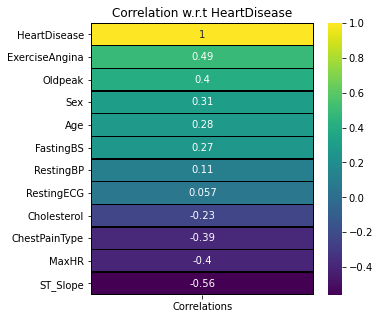

In [274]:
corr = df1.corrwith(df1['HeartDisease']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,cmap = 'viridis',linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t HeartDisease');

In [275]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

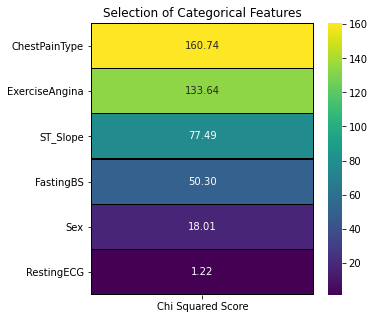

In [276]:
features = df1.loc[:,categorical_features[:-1]]
target = df1.loc[:,categorical_features[-1]]

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,cmap = 'viridis',linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features');

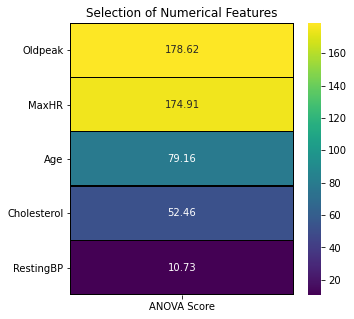

In [277]:
from sklearn.feature_selection import f_classif

features = df1.loc[:,numerical_features]
target = df1.loc[:,categorical_features[-1]]

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = 'viridis',linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');

In [278]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, plot_roc_curve, roc_auc_score, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

In [279]:
features = df1[df1.columns.drop(['HeartDisease','RestingBP','RestingECG'])].values
target = df1['HeartDisease'].values
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state = 2)

In [280]:
def model(classifier):
    
    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Accuracy : ",'{0:.2%}'.format(accuracy_score(y_test,prediction)))
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
    plot_roc_curve(classifier, x_test,y_test)
    plt.title('ROC_AUC_Plot')
    plt.show()

    
    
def model_evaluation(classifier):
        print(classification_report(y_test,classifier.predict(x_test)))

In [281]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# def model(classifier):
#     classifier.fit(x_train, y_train)
#     prediction = classifier.predict(x_test)
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
#     accuracy = accuracy_score(y_test, prediction)
#     cv_score = cross_val_score(classifier, x_train, y_train, cv=cv, scoring='roc_auc').mean()
#     roc_auc = roc_auc_score(y_test, prediction)
    
#     print("Accuracy: {:.2%}".format(accuracy))
#     print("Cross Validation Score: {:.2%}".format(cv_score))
#     print("ROC AUC Score: {:.2%}".format(roc_auc))
    
#     fpr, tpr, thresholds = roc_curve(y_test, prediction)
#     roc_auc = auc(fpr, tpr)
    
#     plt.figure(figsize=(8, 6))
#     plt.plot(fpr, tpr, color='b', label='ROC curve (AUC = {:.2%})'.format(roc_auc))
#     plt.plot([0, 1], [0, 1], color='r', linestyle='--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic')
#     plt.legend(loc='lower right')
#     plt.show()

## LR

In [282]:
from sklearn.linear_model import LogisticRegression

Accuracy :  87.50%
Cross Validation Score :  91.12%
ROC_AUC Score :  87.43%


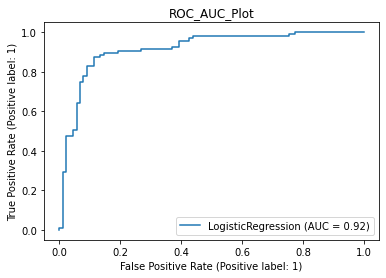

In [283]:
classifier_lr = LogisticRegression(random_state = 0,C=10,penalty= 'l2') 
model(classifier_lr)

In [284]:
model_evaluation(classifier_lr)

              precision    recall  f1-score   support

           0       0.88      0.85      0.87        89
           1       0.87      0.89      0.88        95

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.87       184
weighted avg       0.88      0.88      0.87       184



## SVM

In [285]:
from sklearn.svm import SVC

Accuracy :  87.50%
Cross Validation Score :  90.53%
ROC_AUC Score :  87.43%


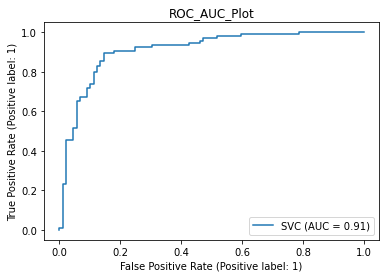

In [286]:
classifier_svc = SVC(kernel = 'linear',C = 0.1)
model(classifier_svc)

In [287]:
model_evaluation(classifier_svc)

              precision    recall  f1-score   support

           0       0.88      0.85      0.87        89
           1       0.87      0.89      0.88        95

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.87       184
weighted avg       0.88      0.88      0.87       184



## DT

In [288]:
from sklearn.tree import DecisionTreeClassifier

Accuracy :  83.70%
Cross Validation Score :  89.38%
ROC_AUC Score :  83.50%


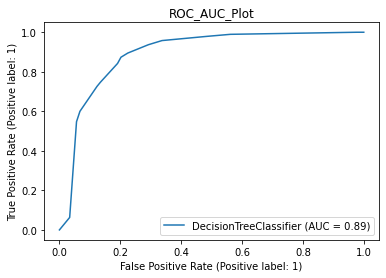

In [289]:
classifier_dt = DecisionTreeClassifier(random_state = 1000,max_depth = 4,min_samples_leaf = 3)
model(classifier_dt)

In [290]:
model_evaluation(classifier_dt)

              precision    recall  f1-score   support

           0       0.87      0.78      0.82        89
           1       0.81      0.89      0.85        95

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



## RF

In [291]:
from sklearn.ensemble import RandomForestClassifier

Accuracy :  84.24%
Cross Validation Score :  92.91%
ROC_AUC Score :  84.06%


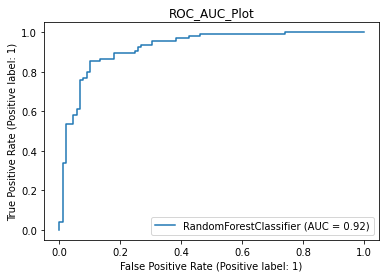

In [292]:
classifier_rf = RandomForestClassifier(max_depth = 4,random_state = 0)
model(classifier_rf)

In [293]:
model_evaluation(classifier_rf)

              precision    recall  f1-score   support

           0       0.88      0.79      0.83        89
           1       0.82      0.89      0.85        95

    accuracy                           0.84       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.84      0.84       184



## KNN

In [294]:
from sklearn.neighbors import KNeighborsClassifier

Accuracy :  81.52%
Cross Validation Score :  89.34%
ROC_AUC Score :  81.36%


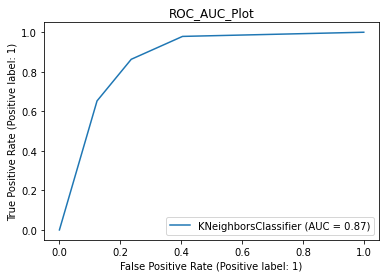

In [295]:
classifier_knn = KNeighborsClassifier(leaf_size = 1, n_neighbors = 3,p = 1)
model(classifier_knn)

In [296]:
model_evaluation(classifier_knn)

              precision    recall  f1-score   support

           0       0.84      0.76      0.80        89
           1       0.80      0.86      0.83        95

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.81       184
weighted avg       0.82      0.82      0.81       184



## AdaBoost

In [297]:
from sklearn.ensemble import AdaBoostRegressor

In [298]:
model_ada = AdaBoostRegressor(n_estimators=15,learning_rate=1.0)
model_ada.fit(x_train, y_train)

AdaBoostRegressor(n_estimators=15)

In [299]:
y_pred = model_ada.predict(x_test)
print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.4798027075399125
MAE 0.3151027385935567


In [300]:
# import optuna
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split

# def objective(trial):
#     max_depth = trial.suggest_int('max_depth', 2, 50)
#     n_estimators = trial.suggest_int('n_estimators', 100, 10000, step=100)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

#     classifier_rf = RandomForestClassifier(
#         max_depth=max_depth,
#         n_estimators=n_estimators,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         random_state=0
#     )

#     classifier_rf.fit(x_train, y_train)
#     y_pred = classifier_rf.predict(x_test)
#     accuracy = accuracy_score(y_test, y_pred)
    
#     return accuracy


# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=1000)

# best_params = study.best_params
# best_accuracy = study.best_value

# print("Best Parameters:", best_params)
# print("Best Accuracy:", best_accuracy)

Accuracy :  84.78%
Cross Validation Score :  92.94%
ROC_AUC Score :  84.62%


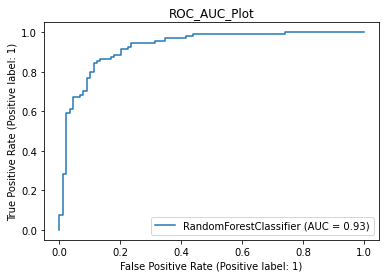

In [301]:
classifier_rf_1 = RandomForestClassifier(max_depth = 8, n_estimators = 7900, min_samples_split = 10, min_samples_leaf = 1)
model(classifier_rf_1)

In [302]:
model_evaluation(classifier_rf_1)

              precision    recall  f1-score   support

           0       0.88      0.80      0.84        89
           1       0.83      0.89      0.86        95

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



Accuracy :  85.33%
Cross Validation Score :  93.14%
ROC_AUC Score :  85.15%


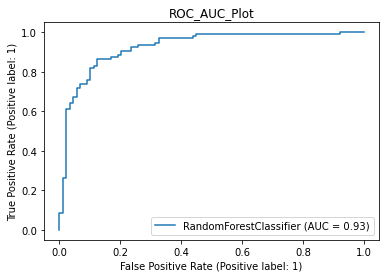

In [303]:
classifier_rf_2 = RandomForestClassifier(max_depth = 34, n_estimators = 7000, min_samples_split = 10, min_samples_leaf = 4)
model(classifier_rf_2)

In [304]:
model_evaluation(classifier_rf_2)

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        89
           1       0.83      0.91      0.86        95

    accuracy                           0.85       184
   macro avg       0.86      0.85      0.85       184
weighted avg       0.86      0.85      0.85       184



In [306]:
import pickle

pickle.dump(classifier_rf_2, open('model.pkl', 'wb'))

In [309]:
df1

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.43,1,1,0.41,0.83,0,1,1.38,0,0.30,2,0
1,-0.48,0,2,1.49,-0.17,0,1,0.75,0,0.41,1,1
2,-1.75,1,1,-0.13,0.77,0,2,-1.53,0,0.30,2,0
3,-0.58,0,0,0.30,0.14,0,1,-1.13,1,0.47,1,1
4,0.05,1,2,0.95,-0.03,0,1,-0.58,0,0.30,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,-0.90,1,3,-1.21,0.60,0,1,-0.19,0,0.43,1,1
914,1.54,1,0,0.63,-0.05,1,1,0.16,0,0.68,1,1
915,0.37,1,0,-0.13,-0.62,0,1,-0.86,1,0.43,1,1
916,0.37,0,1,-0.13,0.34,0,0,1.46,0,0.30,1,1
